The goal is to try to do hierarchical clustering of emojis, based on word2vec, ie cosine similarity between word contexts. 

In [44]:
import re
import math
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from data_cleaning import loader
import src.happyfuntokenizing

from IPython.display import display

## Load files

In [45]:
tweet_df = loader("./data/tweets_training_clean.json")
emojis_df = loader("./data/emoji_webscraped_expanded.json")

In [46]:
def convertEmojis(df):
    """Converts emojis df to printable format """
    emojis = list(map(lambda x: bytes("{}{}".format(*x), 'ascii').decode('unicode-escape'), zip(list(df.byteCode1), list(df.byteCode2)))) 
    return emojis

In [47]:
emojis_df["emojis"] = convertEmojis(emojis_df)

## Training word2vec model

In [53]:
# Tokenising
tok = src.happyfuntokenizing.Tokenizer(preserve_case=False)
tweet_df["tokens"] = [list(tok.tokenize(tweet)) for tweet in tweet_df.text]

In [54]:
# Run once to create and save the word2vec model
# emoji_model = gensim.models.Word2Vec(list(tweet_df.tokens), window=10, size=200, workers=4, min_count=100) 
# emoji_model.save('emoji.embedding')
emoji_model = gensim.models.Word2Vec.load('emoji.embedding')

In [56]:
emoji_model.most_similar(positive = ['🍻'], negative= [])

[('🍸', 0.8616750836372375),
 ('🍹', 0.8468615412712097),
 ('🍺', 0.8321883082389832),
 ('🍷', 0.6295613050460815),
 ('💊', 0.6177286505699158),
 ('🎁', 0.6154630184173584),
 ('🎊', 0.6148277521133423),
 ('🎈', 0.60704505443573),
 ('🎂', 0.6069178581237793),
 ('🍴', 0.6053353548049927)]

## Hierarchical clustering

In [31]:
# Subsetting to faces
def subset_annotations(df):
    annotations = df.annotations
    list_titles = [list(item) for item in list(annotations)]
    index_face_person = [index for index,value in enumerate(list_titles) if 'face' in value] # or 'person' in value]
    df_face_person = df.iloc[index_face_person]
    return df_face_person

In [32]:
def subset_present(df):
    # Select only emojis that are in our model (ie in the corpus)
    return df[df["emojis"].map(lambda x: x in emoji_model.vocab.keys())]

In [33]:
# emojis_df_sub = subset_present(subset_annotations(emojis_df)) # Subset to faces present
emojis_df_sub = subset_present(emojis_df) # Subset to emojis present in our data (at least 100 times)
print(len(emojis_df_sub)) # Number of emojis being categorized

244


In [34]:
# Calculate pairwise distances
combinations = itertools.combinations(emojis_df_sub.emojis, 2)
similarities = []
for combination in combinations:
    try:
        similarities += [emoji_model.similarity(*combination)]
    except Exception:
#         similarities += [np.NAN]
        similarities += [0]
similarities = np.array(similarities)

distances = 1 - np.arccos(similarities) / np.pi # From https://en.wikipedia.org/wiki/Cosine_similarity#Angular_similarity

### Visualise clustering with a dendogram

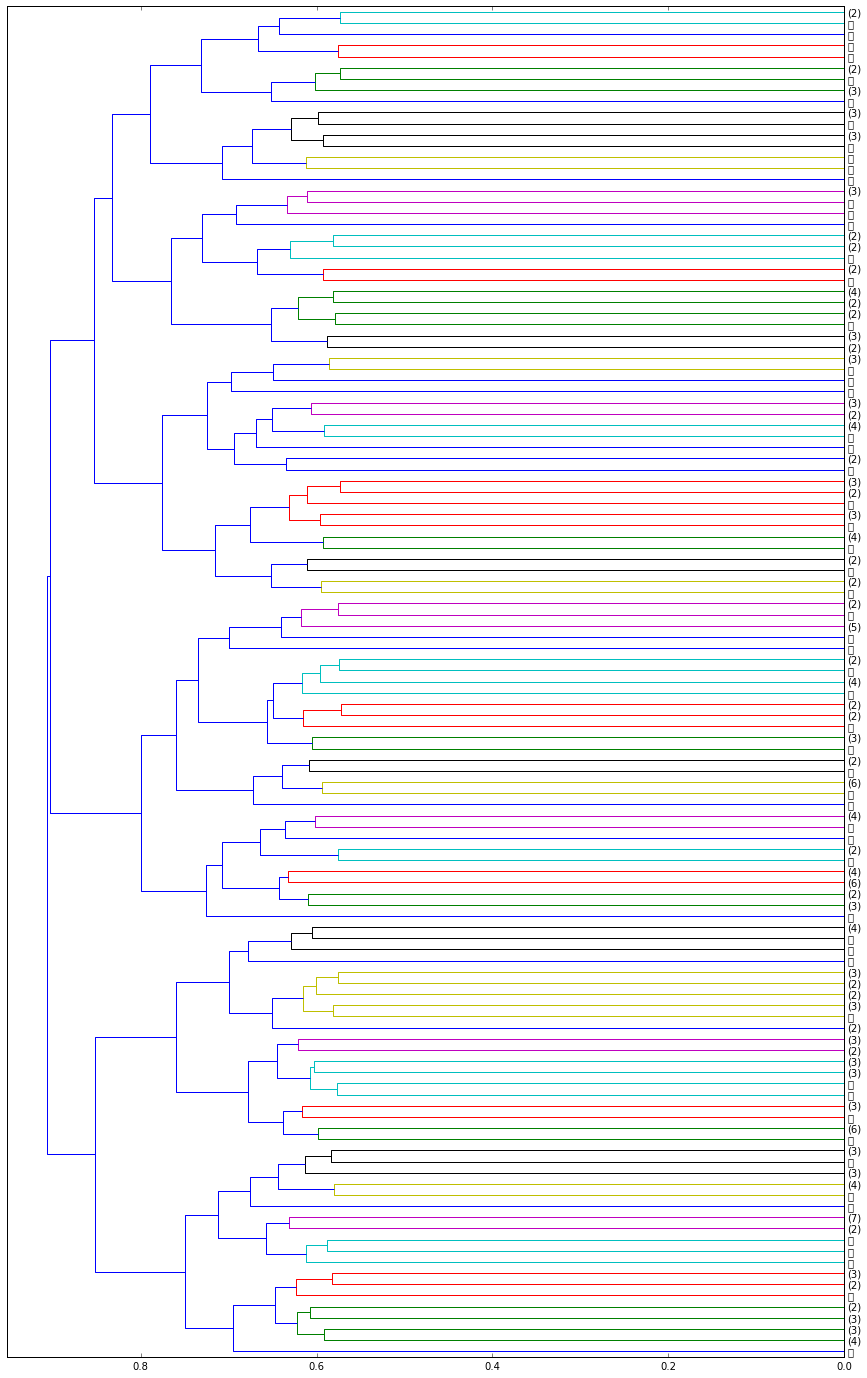

In [35]:
# Cluster with a complete method
hc_linkage = linkage(distances, method="complete")

p = 121 # Number of clusters at which to truncate

# From http://brandonrose.org/clustering
fig, ax = plt.subplots(figsize=(15, 0.2*p)) # set size
R = dendrogram(hc_linkage, orientation="right", labels=list(emojis_df_sub.emojis), truncate_mode="lastp", p=p, get_leaves=True, show_leaf_counts=True, show_contracted=False)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='on')

# plt.tight_layout() #show plot with tight layout
ax.xaxis.grid(True, which='minor')

### Select k clusters based on dendogram

In [42]:
k=18
categories = fcluster(hc_linkage, k, criterion='maxclust')
emojis_df_sub.loc[:,"category"] = categories

In [43]:
for category in range(1, k+1):
    print("Category {}".format(category))
    emojis_cat = emojis_df_sub[emojis_df_sub["category"] == category]
    for emoji in emojis_cat.emojis:
        print(emoji, end="")
    print("\n")

Category 1
👼😍💆🙅💃👇😐🐶🐬🍗☕😄😖💧🎊🎀😬😈💸

Category 2
😀👲💁💏👭👉👅💔💚💫🐴🌹🍁😴😌😛🍪🍻😕🚙🌚☀👹💀💩

Category 3
🙏👆👎❤💞💭💍🐫🐾🌿🍔🌉✈😲🌈😆😩🏀😡🎧😸💉😋❗

Category 4
🙇😚👍👀💋💜💦😑😮🌻😪🌵🍰😦⛄⚾🏆📖👻👨

Category 5
👯🙋👫☝👌💗😣🍃🍫😝🍸🚗😞😭🌝⚡😨🔥🏈♥🔊😉🎥⬇

Category 6
💄

Category 7
🙆🙌👬✌🐯🌾🍦😟🔕💵💲

Category 8
😁😎👋💅💘💨🐷🌴🍩😷🎈⚽😵🎼😠👽🙈

Category 9
✊✋💙💤🌸😯🍣🌙🌟🎃

Category 10
🙍😙💪👈👊💓😂🐘🍟🍷⚓😤😢🌞🌀🎁😱📚💰😻👶

Category 11
🚶💕😇😶🐑😏🌺😫🍴😔🎶💊✔🙊

Category 12
😘💎🍺☁🏊🔫

Category 13
🏃🐻🍂🎂😒😧🌊😰🎵😊🔪😹🙉💯

Category 14
☺💢💣👑🐱🐪🍜❄

Category 15
💖🌲🍹😓✂🙀

Category 16
👐💛🍕😜🍭☔✨😳👿✏👵

Category 17
👸💂👏😥😃⛅🎤

Category 18
💑💥🍝😅⭐🎉

